In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DISPLAY_DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/"
DATASET_PATH = "/kaggle/input/fashion-product-images-small/"
print(os.listdir(DATASET_PATH))

['myntradataset', 'images', 'styles.csv']


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=15000, on_bad_lines="skip")
# df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines="skip")
print(df.shape)
df.head()

(15000, 10)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt

In [5]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: user 211 ms, sys: 497 ms, total: 707 ms
Wall time: 1min 7s


In [6]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg

In [7]:
df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              4
season                  6
year                    0
usage                 101
productDisplayName      2
image                   1
dtype: int64

In [8]:
df = df.dropna(subset=['image'])

In [9]:
df.shape

(14999, 11)

In [10]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img,display=False):
    if display :
        return DISPLAY_DATASET_PATH+"/images/"+img
    else :
        return DATASET_PATH+"/images/"+img

def load_image(img,display=False):
    return cv2.imread(img_path(img,display))

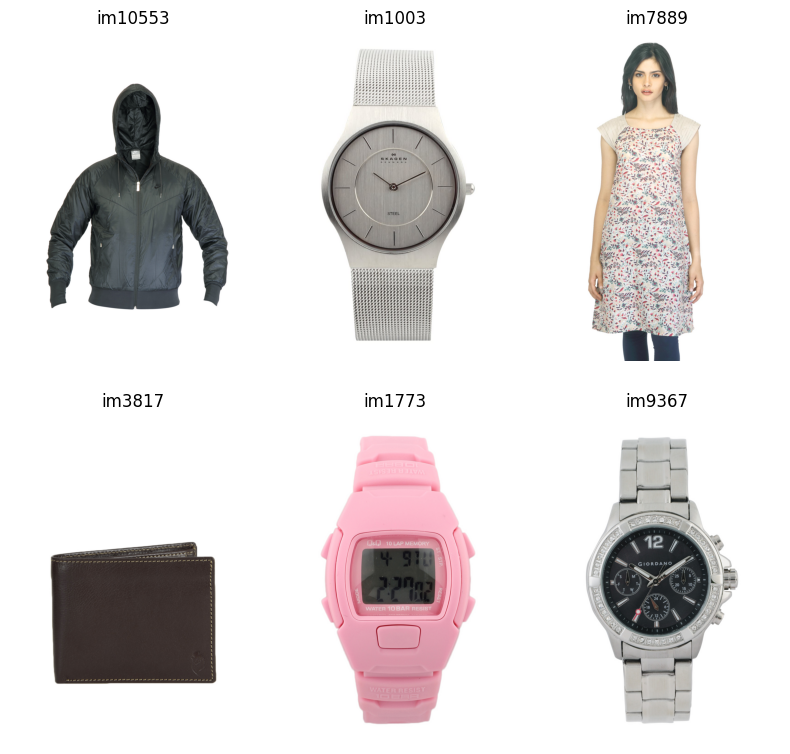

In [11]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

<AxesSubplot: >

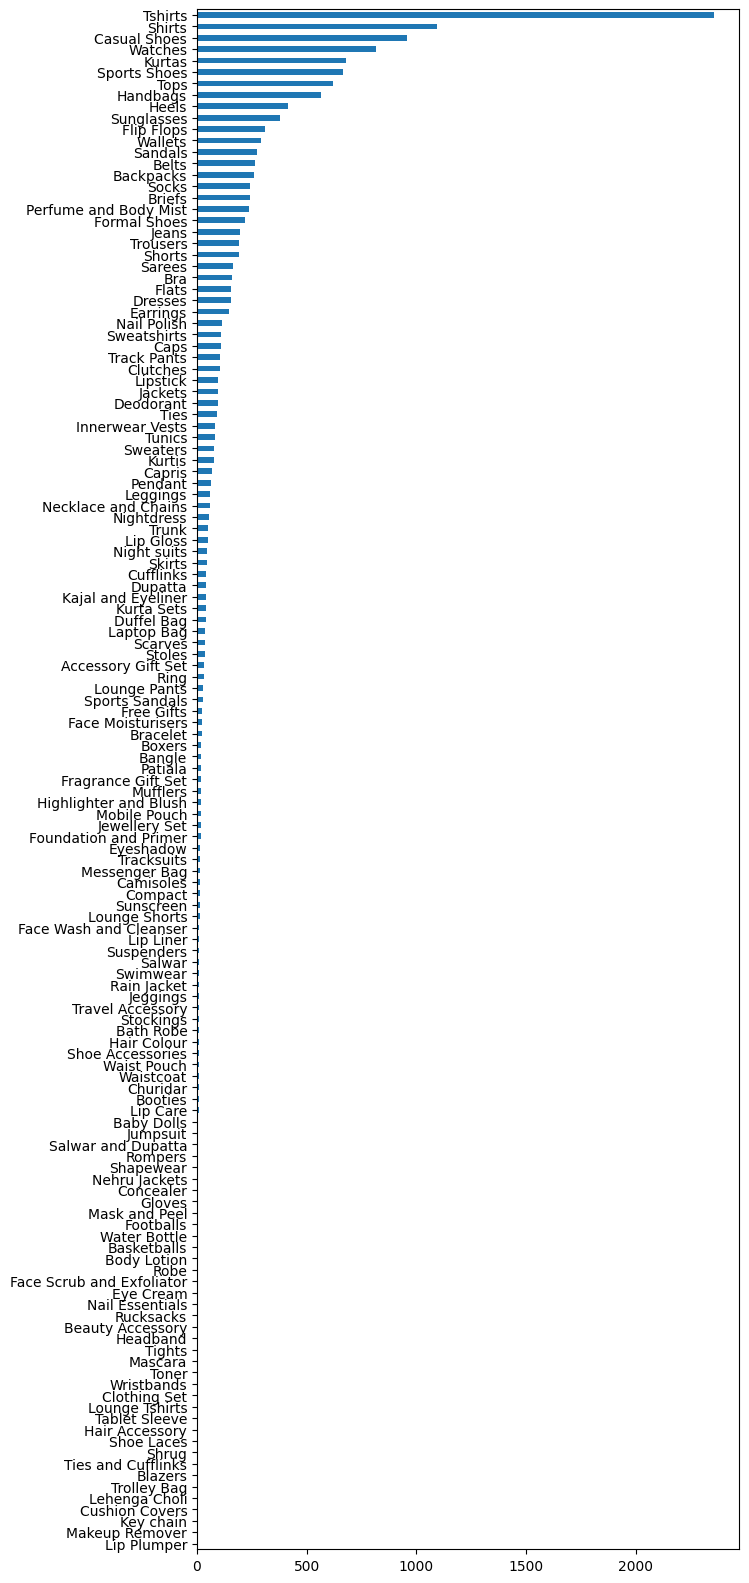

In [12]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [13]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.11.0'

In [14]:
# tf.config.list_physical_devices('GPU')

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [15]:
# Input Shape
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
i = 0
import time
start_time = time.time()
def get_embedding(model, img_name):
    global i, start_time
    if((i < 1000 and i%50 == 0) or i%200 == 0):
        print(i, "Time elapsed so far: {:.2f} minutes".format((time.time() - start_time) / 60))
    i += 1
    
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x,verbose=0).reshape(-1)

In [17]:
emb = get_embedding(model, df.iloc[59].image)
emb.shape

0 Time elapsed so far: 0.00 minutes


(2048,)

[0.498429  4.9910555 0.        ... 2.8357239 4.693335  0.       ]


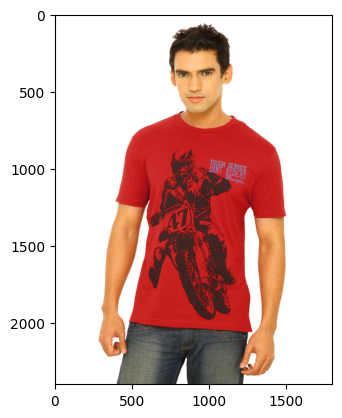

In [18]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[59].image,True), cv2.COLOR_BGR2RGB))
print(emb)

In [19]:
import dask.dataframe as dd

# Create a Dask dataframe from your Pandas dataframe
# dask_df = dd.from_pandas(df, npartitions=8)
dask_df = dd.from_pandas(df, npartitions=32)

# Define the expected output type of your function
meta = pd.Series([], dtype=float)

In [20]:
%%time
import time
start_time = time.time()
i = 0

# Apply the function to each partition of the dataframe in parallel
dask_result = dask_df['image'].map(lambda img: get_embedding(model, img), meta=meta)

# Compute the result
result = dask_result.compute().reset_index(drop=True)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_11
...............vars
............activation_12
...............vars
............activation_13
...............vars
............activation_14
...............vars
............activation_15
...............vars
............activation_16
...............vars
............activation_17
...............vars
............activation_18
...............vars
............activation_19
...............vars
............activation_2
...............vars
............activation_20
...............vars
............activation_21
...............vars
............activation_22
...............vars
............activation_23
...............vars
............activation_24
...............vars
............activation_25
...............vars
............activation

In [21]:
print(result.shape)
result.head()

(14999,)


0    [0.0, 3.651422, 0.0, 0.75223374, 0.0, 0.0, 4.1...
1    [1.8793392, 1.6008826, 0.09203717, 4.433073, 0...
2    [0.0, 0.31120038, 0.0, 3.808678, 0.43703175, 7...
3    [0.5880205, 9.894607, 0.0, 6.2953253, 1.783724...
4    [0.0, 1.8829775, 0.0, 5.122095, 0.0, 0.0, 2.95...
Name: image, dtype: object

In [22]:
df_embds = result.apply(pd.Series)

In [23]:
print(df_embds.shape)
df_embds.head()

(14999, 2048)


0         1         2         3         4         5         6     \
0  0.000000  3.651422  0.000000  0.752234  0.000000  0.000000  4.103789   
1  1.879339  1.600883  0.092037  4.433073  0.000000  0.000000  3.030755   
2  0.000000  0.311200  0.000000  3.808678  0.437032  7.112508  0.000000   
3  0.588021  9.894607  0.000000  6.295325  1.783724  1.913129  0.000000   
4  0.000000  1.882977  0.000000  5.122095  0.000000  0.000000  2.950297   

        7         8     9     ...       2038    2039      2040      2041  \
0   2.382157  2.472518   0.0  ...   0.366396  0.0000  0.000000  6.000692   
1   8.530585  5.498660   0.0  ...   2.808287  0.0000  3.923504  3.183100   
2   0.000000  0.000000   0.0  ...   0.218202  7.8613  1.655930  0.000000   
3  13.309930  7.805779   0.0  ...  22.434397  0.0000  0.000000  0.000000   
4   6.626852  1.606635   0.0  ...   2.504939  0.0000  1.274124  3.484580   

       2042      2043      2044      2045      2046      2047  
0  0.000000  0.000000  6.389913  4.246411  1.067708  1.671672  
1  0.000000  0.000000  4.244196  3.268897  2.271736  5.433372  
2  0.000000  0.000000  4.702999  0.000000  2.340579  0.000000  
3  2.565928  3.330492  0.594363  1.130459  3.084232  7.608919  
4  0.786348  0.000000  1.597860  2.515501  0.068349  0.000000  

[5 rows x 2048 columns]

In [24]:
from scipy import sparse

# df_embds.to_csv("df_embds_img.csv",index=False)
# Convert DataFrame to a sparse matrix
sparse_matrix = sparse.csr_matrix(df_embds.values)

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_img.npz', sparse_matrix)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate the text columns into a single column
df['combined_text'] = [' '.join(row) for row in df[['gender', 'masterCategory', 'subCategory', 'articleType',
                                                     'baseColour', 'season', 'year', 'usage',
                                                     'productDisplayName']].values.astype(str)]


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined_text column
tfidf_embeddings = vectorizer.fit_transform(df['combined_text'])

# tfidf_embeddings is a sparse matrix containing the TF-IDF vectors
tfidf_embeddings

<14999x5074 sparse matrix of type '<class 'numpy.float64'>'
	with 169210 stored elements in Compressed Sparse Row format>

In [26]:
from scipy import sparse

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_tfidf.npz', tfidf_embeddings)

In [27]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_imgs = 1-pairwise_distances(df_embds, metric='cosine')
cosine_sim_imgs[:4, :4]

array([[1.        , 0.5789429 , 0.2381556 , 0.4910105 ],
       [0.5789429 , 0.99999994, 0.2395134 , 0.7227353 ],
       [0.2381556 , 0.2395134 , 1.        , 0.2201165 ],
       [0.4910105 , 0.7227353 , 0.2201165 , 1.        ]], dtype=float32)

In [28]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_tfidf = 1-pairwise_distances(tfidf_embeddings, metric='cosine')
cosine_sim_tfidf[:4, :4]

array([[1.        , 0.18218686, 0.00698982, 0.08623057],
       [0.18218686, 1.        , 0.00593168, 0.08422119],
       [0.00698982, 0.00593168, 1.        , 0.00504161],
       [0.08623057, 0.08422119, 0.00504161, 1.        ]])

In [29]:
cosine_sim = cosine_sim_tfidf * 0.3 + cosine_sim_imgs * 0.7

In [30]:
print(cosine_sim.shape)
cosine_sim[:4,:4]

(14999, 14999)


array([[0.99999999, 0.45991609, 0.16880586, 0.36957649],
       [0.45991609, 0.99999993, 0.16943887, 0.53118105],
       [0.16880586, 0.16943887, 0.99999999, 0.15559402],
       [0.36957649, 0.53118105, 0.15559402, 0.99999999]])

In [31]:
indices = pd.Series(range(len(df)), index=df.index)
indices.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [32]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [33]:
get_recommender(993, df, top_n = 5)

(Int64Index([3029, 1256, 6355, 12781, 6320], dtype='int64'),
 [0.9765068769454956,
  0.9331244623116046,
  0.926786231994629,
  0.9242892739829793,
  0.9168566346168519])

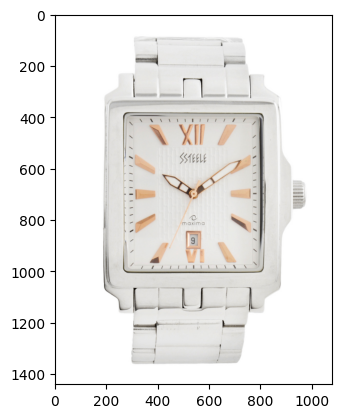

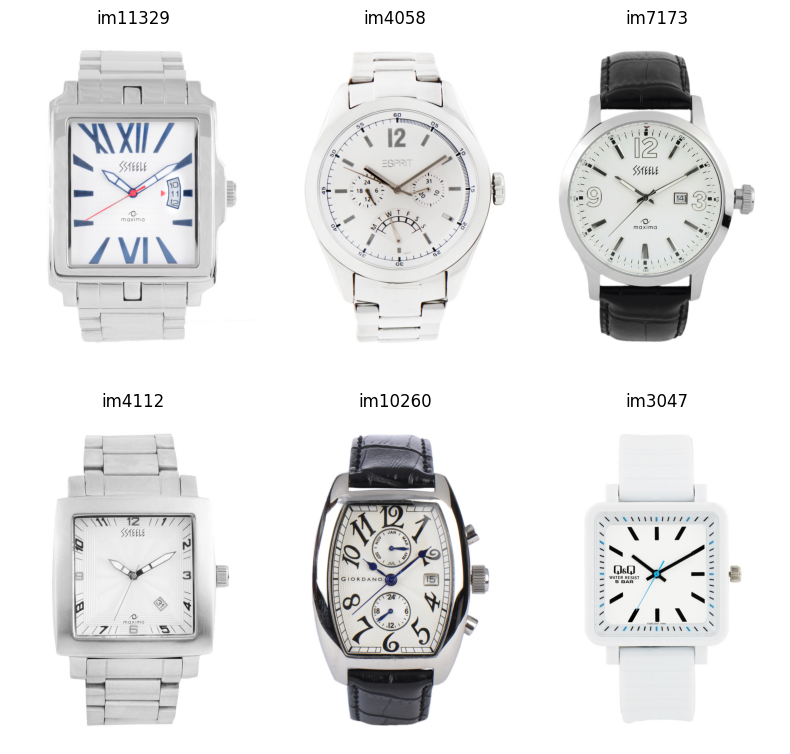

In [34]:
# Idx Item to Recommender
idx_ref = 675

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image,True), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [35]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [36]:
%%time
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embds)

CPU times: user 2min 14s, sys: 1.02 s, total: 2min 15s
Wall time: 1min 13s


In [37]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot: >

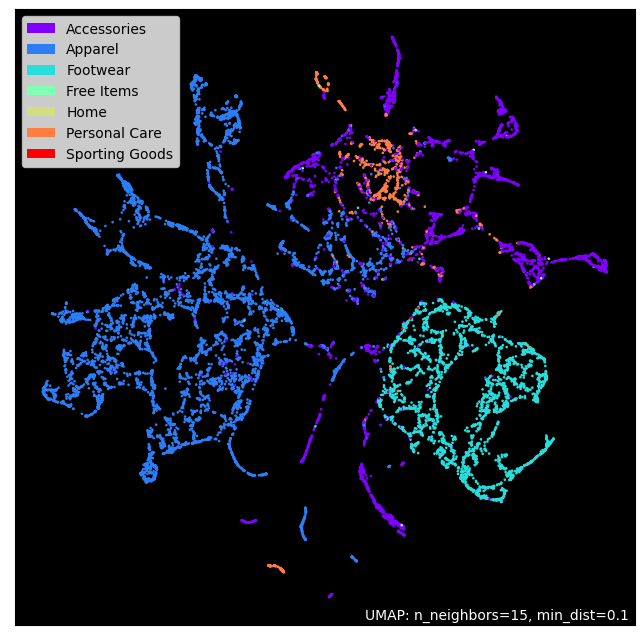

In [38]:
import umap.plot
mapper_org = umap.UMAP().fit(tsne_results)
umap.plot.points(mapper_org, labels=df["masterCategory"], theme='fire')

<AxesSubplot: >

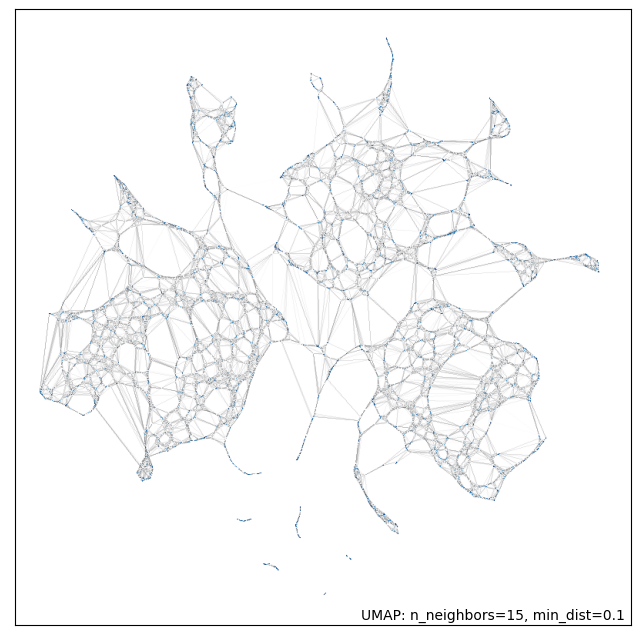

In [39]:
umap.plot.connectivity(mapper_org, show_points=True)

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

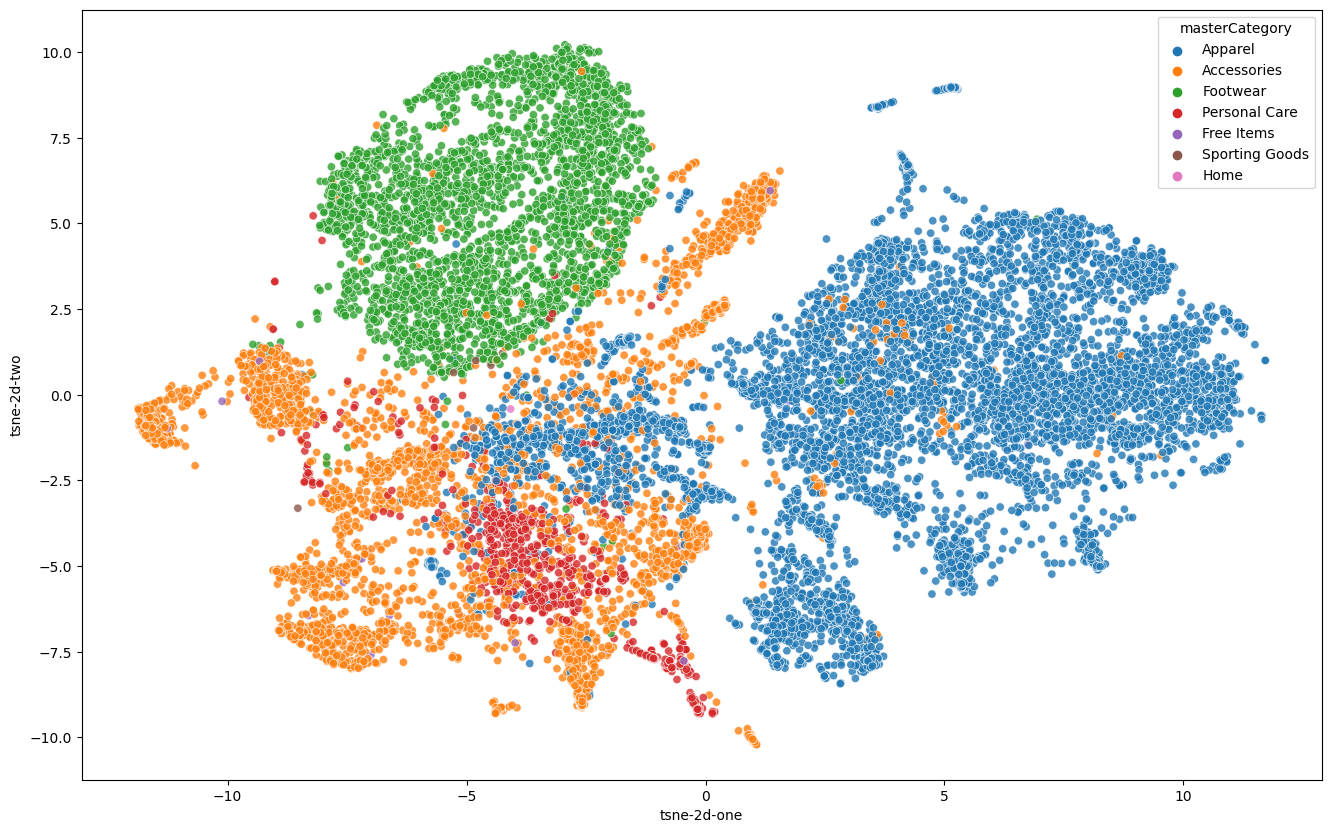

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

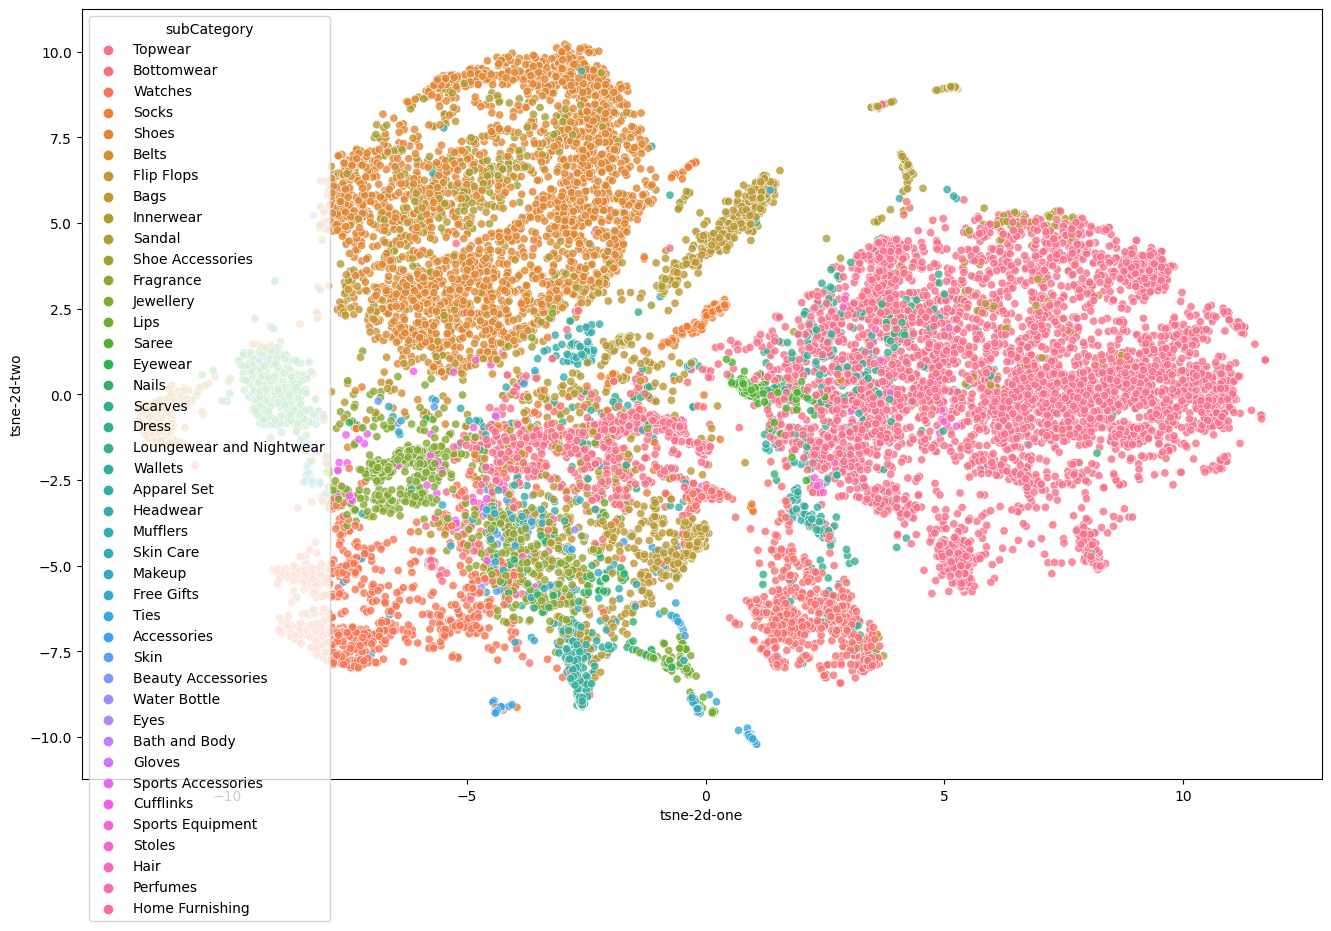

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(2)
pca.fit(df_embds)
train_pca = pca.transform(df_embds)

In [44]:
train_pca = pd.DataFrame(train_pca)
train = df.iloc[:,0:10]
train = df.merge(train_pca, how='left', left_index=True, right_index=True)
train.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName      image  \
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg   
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg   
2  2016  Casual                       Titan Women Silver Watch  59263.jpg   
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg   
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg   

                                       combined_text  tsne-2d-one  \
0  Men Apparel Topwear Shirts Navy Blue Fall 2011...     5.387496   
1  Men Apparel Bottomwear Jeans Blue Summer 2012 ...     1.760307   
2  Women Accessories Watches Watches Silver Winte...    -7.461882   
3  Men Apparel Bottomwear Track Pants Black Fall ...     1.444210   
4  Men Apparel Topwear Tshirts Grey Summer 2012 C...     7.796133   

   tsne-2d-two          0          1  
0    -4.670112  66.614586  -3.090164  
1    -6.950311  45.458221   1.767646  
2    -3.978999 -38.571190 -57.499554  
3    -7.760309  45.901024   1.486791  
4     0.511685  76.685577   4.610520

In [45]:
import plotly.express as px
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [46]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [47]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()


In [48]:
fig = px.scatter(train[train['season'].notna()], x=0, y=1, color="season", title='Season', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [49]:
fig = px.scatter(train[train['usage'].notna()], x=0, y=1, color="usage", title='Usage', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [50]:
pca = PCA()
pca.fit(df_embds)
train_pca = pca.transform(df_embds)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

In [51]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [52]:
val_pca = pca.fit_transform(df_embds)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = df.iloc[:,0:11]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)
val = val.dropna()

In [53]:
X = val.iloc[:,-313:]
y = val.index

In [54]:
X.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
308    0
309    0
310    0
311    0
312    0
Length: 313, dtype: int64

In [55]:
 X.columns = X.columns.astype(str)

In [56]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



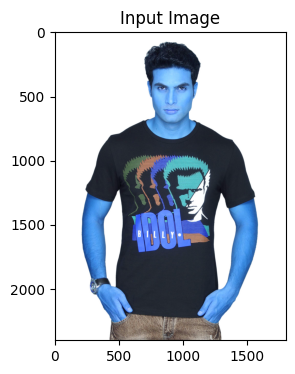

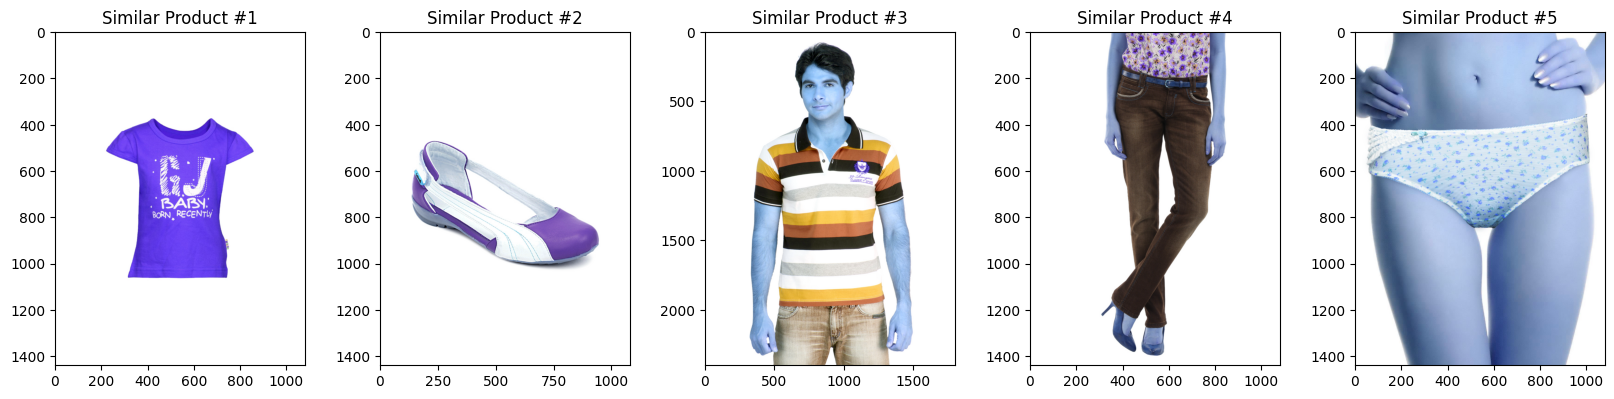

In [57]:
import random
for _ in range(1):
    i = random.randint(1,len(val))
    img1 = load_image(val.loc[i,'image'],True)
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = load_image(val.loc[index[0][i],'image'],True)
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')